In [7]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv
load_dotenv()
# DATASET_PATH=os.getenv("DATASET_DIRECTORY")
DATASET_PATH="/data/RadVel"
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")

sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS
from mmwave_radar_processing.processors.range_azmith_resp import RangeAzimuthProcessor
from mmwave_radar_processing.processors.range_doppler_resp import RangeDopplerProcessor
from mmwave_radar_processing.processors.doppler_azimuth_resp import DopplerAzimuthProcessor
from mmwave_radar_processing.processors.micro_doppler_resp import MicroDopplerProcessor
from mmwave_radar_processing.processors.virtual_array_reformater import VirtualArrayReformatter
from mmwave_radar_processing.plotting.plotter_mmWave_data import PlotterMmWaveData
from mmwave_radar_processing.plotting.movies_mmWave_data import MovieGeneratorMmWaveData


In [8]:
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"1843_RadVel_20Hz.cfg")
# cfg_path = os.path.join(CONFIG_DIRECTORY,"RadSAR_2_sr.cfg")
cfg_manager.load_cfg(cfg_path)
cfg_manager.compute_radar_perforance(profile_idx=0)
print(cfg_manager.vel_res_m_s)

0.050172790534208055


In [9]:
#load the dataset
# dataset_name = "NORTH_RadSAR_TRAIN_1"
dataset_name = "CPSL_RadVel_20Hz_1"
dataset_path = os.path.join(DATASET_PATH,dataset_name)
print(dataset_path)
# dataset_name = "RadSAR_2_CPSL"
# dataset_path = os.path.join(DATASET_PATH,os.pardir,"RadSAR",dataset_name)
dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="radar_0_adc",
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_orientation", #not implemented
    imu_full_folder="imu_data",
    vehicle_vel_folder="vehicle_vel",
    vehicle_odom_folder="vehicle_odom"
)

/data/RadVel/CPSL_RadVel_20Hz_1
found 160 radar samples
did not find lidar samples
found 160 camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
found 160 vehicle velocity samples
found 160 vehicle odometry samples


In [10]:
#load the plotter
plotter = PlotterMmWaveData(config_manager=cfg_manager)
plotter.min_threshold_dB = 60

#initialize a range azimuth processor
range_az_processor = RangeAzimuthProcessor(
    config_manager=cfg_manager,
    num_angle_bins=64
)

#initialize the range doppler processor
range_doppler_processor = RangeDopplerProcessor(
    config_manager=cfg_manager
)

doppler_azimuth_processor = DopplerAzimuthProcessor(
    config_manager=cfg_manager,
    num_angle_bins=64
)

micro_doppler_processor = MicroDopplerProcessor(
    config_manager=cfg_manager,
    target_ranges=np.array([3.0,3.7]),
    num_frames_history=20
)

#load the ADC data reformatter
virtual_array_reformatter = VirtualArrayReformatter(config_manager=cfg_manager)

#initialize the movie generator
movie_generator = MovieGeneratorMmWaveData(
    cpsl_dataset=dataset,
    plotter=plotter,
    range_azimuth_processor=range_az_processor,
    range_doppler_processor=range_doppler_processor,
    doppler_azimuth_processor=doppler_azimuth_processor,
    micro_doppler_processor=micro_doppler_processor,
    virtual_array_reformatter=virtual_array_reformatter,
    temp_dir_path=os.path.join("~/Downloads/RadVel",dataset_name)
)

found temp dir: /home/david/Downloads/RadVel/CPSL_RadVel_20Hz_1
clearing temp directory /home/david/Downloads/RadVel/CPSL_RadVel_20Hz_1


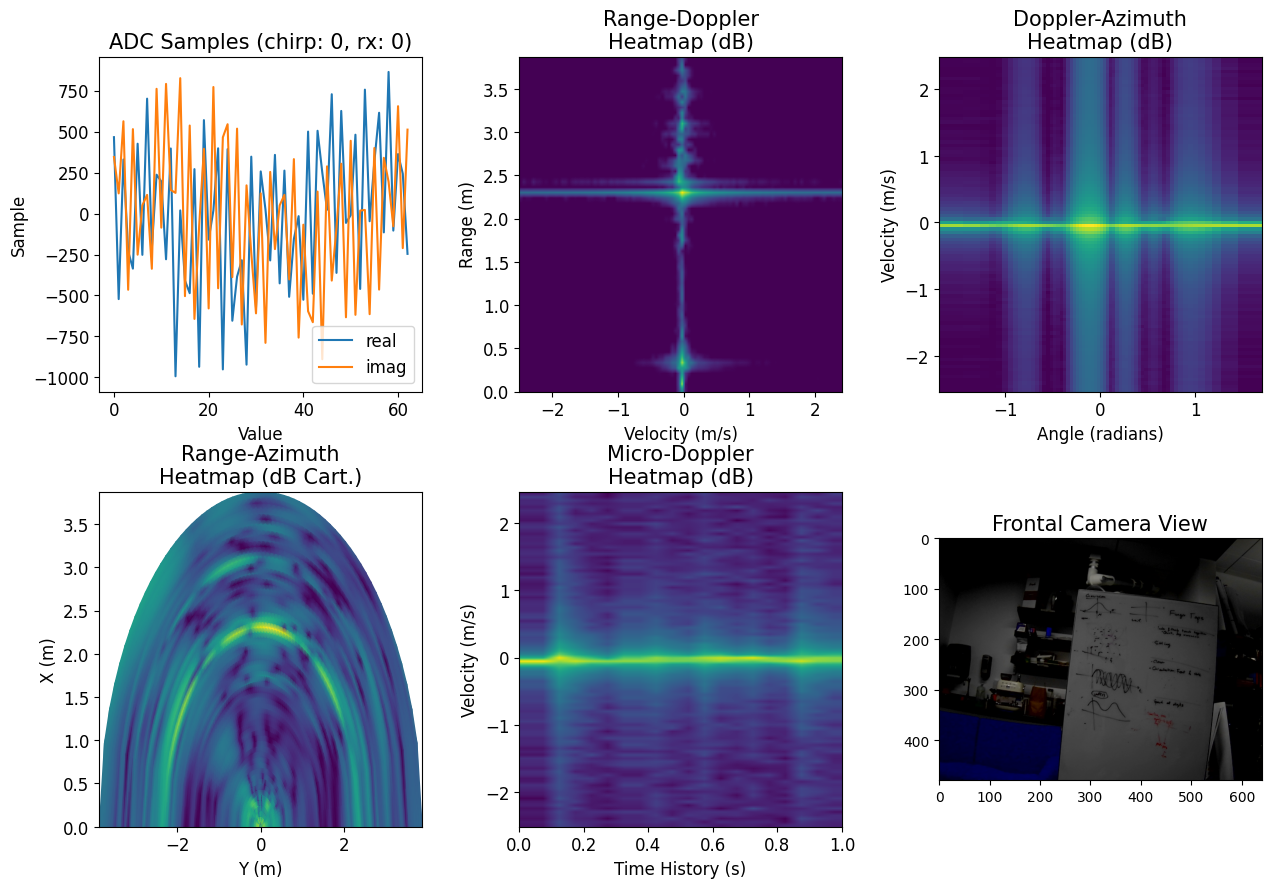

In [11]:
#for getting access to the adc cube
idx=0
#compute responses over a series of frames
for i in range(micro_doppler_processor.num_frames_history):

    #get the ADC cube
    adc_cube = dataset.get_radar_data(idx + i)

    adc_cube = virtual_array_reformatter.process(adc_cube)
    rng_az_resp = range_az_processor.process(adc_cube=adc_cube,chirp_idx=0)
    rng_dop_resp = range_doppler_processor.process(adc_cube=adc_cube,rx_idx=0)
    dop_az_resp = doppler_azimuth_processor.process(adc_cube=adc_cube)
    micro_doppler_resp = micro_doppler_processor.process(adc_cube=adc_cube,rx_idx=0)

    try:
        camera_view = dataset.get_camera_frame(idx + i)
    except AssertionError:
        camera_view = np.empty(shape=(0))

#for generating a compilation of plots
fig,axs=plt.subplots(2,3, figsize=(15,10))
fig.subplots_adjust(wspace=0.3,hspace=0.30)

plotter.plot_compilation(
    adc_cube=adc_cube,
    range_doppler_processor=range_doppler_processor,
    range_azimuth_processor=range_az_processor,
    doppler_azimuth_processor=doppler_azimuth_processor,
    micro_doppler_processor=micro_doppler_processor,
    camera_view=camera_view,
    convert_to_dB=True,
    cmap="viridis",
    chirp_idx=0,
    rx_antenna_idx=0,
    axs=axs,
    show=True
)

  0%|          | 0/160 [00:00<?, ?it/s]

100%|██████████| 160/160 [00:11<00:00, 13.70it/s]


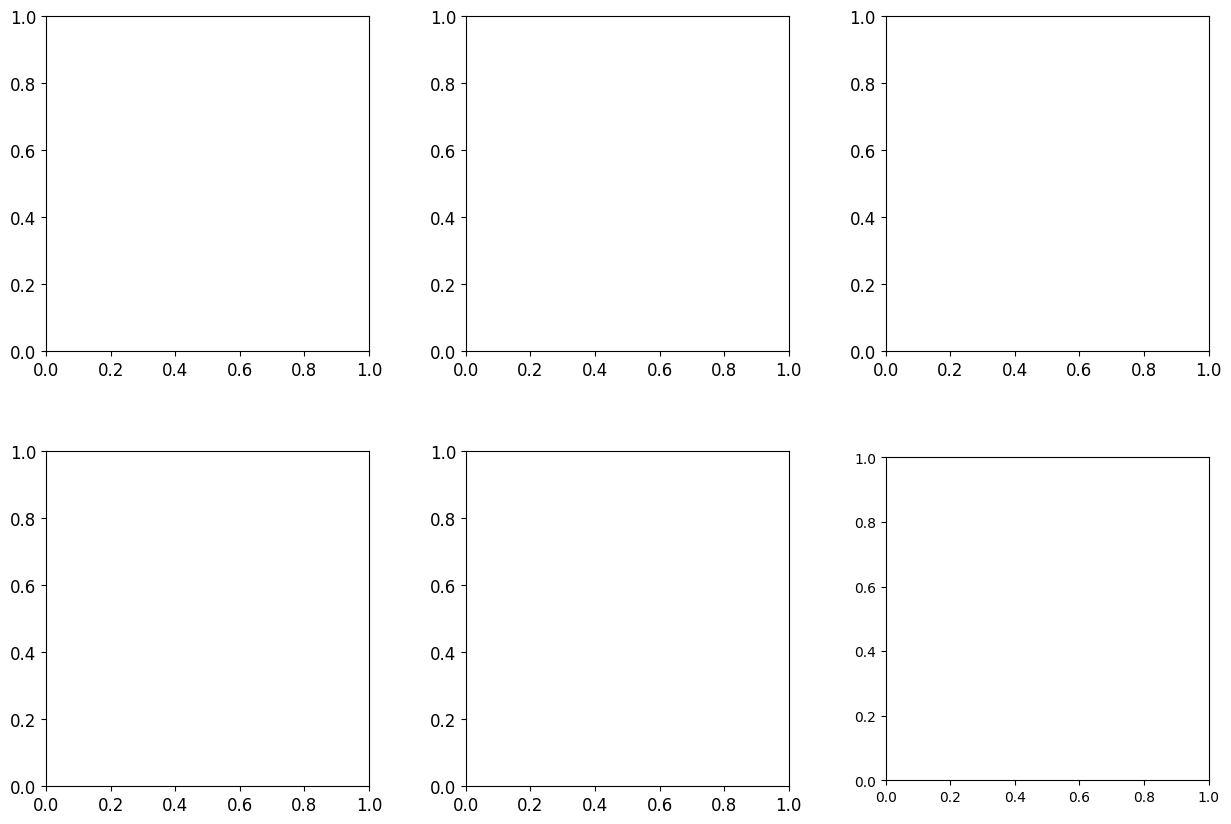

In [12]:
#generate the movie - initialize the figure
movie_generator.initialize_figure(nrows=2,ncols=3,figsize=(15,10))

#reset the microdoppler signature
movie_generator.micro_doppler_processor.micro_doppler_resp = np.zeros_like(movie_generator.micro_doppler_processor.micro_doppler_resp)

#generate the movie frames
movie_generator.generate_movie_frames(
    chirp_idx=0,
    rx_antenna_idx=0,
    cmap="viridis",
    convert_to_dB=True
)

fps = 1 / (1e-3 * cfg_manager.frameCfg_periodicity_ms)
movie_generator.save_movie(video_file_name="{}_raw.mp4".format(dataset_name),fps=fps)